<a href="https://colab.research.google.com/github/kaushil268/Movie-Review-Sentiment-Analysis/blob/master/Movie_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

In [0]:
from google.colab import files

train= files.upload()




Saving train.tsv to train.tsv


In [0]:
test = files.upload()
train= pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test.tsv", sep="\t")

Saving test.tsv to test (3).tsv


In [0]:
def clean_sentences(df):
    
    
    
    '''
        This function will take each phrase iteratively and it will
        remove html content
        remove non-alphabetic characters
        tokenize the sentences
        lemmatize each word to its lemma

    '''
    
    
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)


In [0]:
#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

  0%|          | 1/156060 [00:01<66:14:04,  1.53s/it]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 66292/66292 [00:23<00:00, 2762.35it/s]

156060
66292


In [0]:
#Collect the dependent values and convert to one-hot encoded output using to_categorical

target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [0]:
#split into train and validation sets

X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [0]:
#Geting the no of unique words and max length of a review available in the list of cleaned reviews
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 661681.12it/s]

13741
48


In [0]:
#Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [0]:

#early stopping to prevent overfitting

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [0]:
#Model using Keras LSTM

#We will build the Long Short Term Memory network ehich is one of the most popular type of model in NLP at the moment. 
#This architecture is specially designed to work on sequence data.
#It treats the text as a sequence rather than a bag of words or as ngrams.


model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4122300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,398,361
Trainable params: 4,398,361
Non-trainable params: 0
____________________________________________

In [0]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 99s 795us/step - loss: 1.0151 - accuracy: 0.5922 - val_loss: 0.8438 - val_accuracy: 0.6519
Epoch 2/6


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


124848/124848 [==============================] - 97s 780us/step - loss: 0.8188 - accuracy: 0.6647 - val_loss: 0.8101 - val_accuracy: 0.6696
Epoch 3/6
124848/124848 [==============================] - 96s 766us/step - loss: 0.7547 - accuracy: 0.6887 - val_loss: 0.8015 - val_accuracy: 0.6748
Epoch 4/6
124848/124848 [==============================] - 96s 771us/step - loss: 0.7193 - accuracy: 0.7010 - val_loss: 0.8012 - val_accuracy: 0.6747
Epoch 5/6
124848/124848 [==============================] - 96s 772us/step - loss: 0.6958 - accuracy: 0.7112 - val_loss: 0.8110 - val_accuracy: 0.6798
Epoch 6/6
124848/124848 [==============================] - 98s 781us/step - loss: 0.6785 - accuracy: 0.7176 - val_loss: 0.8325 - val_accuracy: 0.6770


Text(0, 0.5, 'Loss')

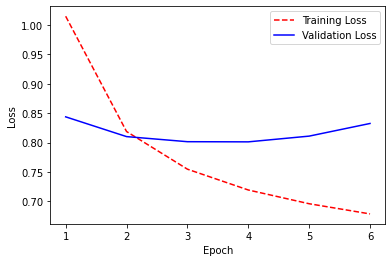

In [0]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')